# Making and Testing Dips 

In this notebook, we're going to simulate some dips

In [76]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import numpy as np
import pandas as pd

import lightkurve as lk
from dipper import measure_dip
from simulations import identify_dips, simulate_lightcurves, run_simulations, simulate_dip_flux, get_ztf_lightcurve


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Kyle has a basic function in his notebook that I think we can extend:

In [2]:
def simulate_dip_flux(tseg=20, coverage=3.0, width=5, depth=0.2, tdip=None):
    """
    Simulate normalized flux for one or multiple dips on an evenly sampled 
    grid.
    
    Parameters
    ----------
    tseg : float
        The duration of the total light curve in days
    
    coverage : float
        The number of data points per day in the finely 
        sampled light curve.
        
    width : float, or iterable
        The width of the dip in days
        
    depth : float [0,1], or iterable
        The depth of the dip, as a fraction of the flux normalized to 1. 
        Must be between 0 and 1
    
    tdip : float
        
    err : float
        The uncertainty on the data points
        
    Returns
    -------
    time : numpy.ndarray
        An array with time stamps for the flux measurements
        
    flux : numpy.ndarray
        An array with the flux measurements
    
    """
    # if my width and depth are numbers, I want to turn them 
    # into arrays so I can loop over them and won't need to 
    # treat that case separately later
    if np.size(width) == 1:
        width = np.array([width])
    if np.size(depth) == 1:
        depth = np.array([depth])
        
    # if tdip is None, then randomly scatter dip into the 
    # light curve, otherwise make sure it's an array
    if tdip is not None:
        if np.size(tdip) == 1:
            tdip = np.array([tdip])
    else:
        # if there's only one, stick it into the middle
        if np.size(width) == 1:
            tdip = np.array([tseg/2.0])
        # if there's more than one dip, scatter through light curve
        # at regular intervals
        else:
            w = np.max(width) * 5.0
            tdip = np.linspace(w, tseg-w, len(width))

    # check that inputs are correct
    if np.any(width >= tseg):
        raise ValueError("The dip must be smaller than the length of the light curve.")
        
    # check that the depth is smaller than 1, or we'll have negative flux
    if np.any(depth >= 1.0):
        print(type(depth))
        print(np.any(depth) >= 1.0)
        print("depth: " + str(depth))
        raise ValueError("The depth of the dip must be < 1.")
        
    # the number of points is the days times the coverage:
    npoints = int(tseg * coverage)
    
    # create evenly sampled time array
    time = np.linspace(0.0, tseg, npoints) 

    # make flux
    if np.size(depth) > 1:
        flux = 1.0
        for i in range(len(depth)):
            flux -= depth[i] * np.exp(-(time-tdip[i])**2 / (2 * width[i]**2))   
    else:
        flux = 1.0 - depth * np.exp(-(time-tdip)**2 / (2 * width**2))
         
    return time, flux

Let's simulate a light curve and see what it looks like:

In [3]:
coverage = 5
tseg = 1000
width = 5.0
depth = 0.2

time, flux = simulate_dip_flux(tseg, coverage, width, depth)

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.scatter(time, flux, color="black", s=4)


Okay, cool, now we want to generate light curves:

In [5]:
def simulate_lightcurves(time, flux, nbands=1, cadence=None, npoints=None, 
                         err=0.02, mean_mag=12.0):
    
    if cadence is None and npoints is None:
        raise ValueError("Either cadence or npoints need to have a value.")
        
    if cadence is not None:
        if cadence.shape[0] != nbands:
            raise ValueError("Need to have a set of cadences for all bands defined in `nbands`")
    
    if npoints is not None:
        if np.size(npoints) != nbands:
            raise ValueError("Need to have a set of `npoints` for all bands defined in `nbands`")

    if np.size(err) != 1 and len(err) != nbands:
        raise ValueError("The errors need to be either a single number or a list" + \
                         "of numbers corresponding to the number of bands.")

        
    if np.size(mean_mag) == 1:
        mean_mag = np.array([mean_mag])
        
    if np.size(err) == 1:
        err = np.array([err])
        
    if np.size(npoints) == 1:
        npoints = np.array([npoints])

    if cadence is not None:
        npoints = np.array([len(c) for c in cadence])
        #print("npoints: " + str(npoints))
        #print("cadence: " + str(cadence))
        
    lc_all = []
    # loop over different bands:
    for i in range(nbands):
        # if the cadence is not defined, randomly sample from times 
        if cadence is None:
            #print("i: " + str(i))
            #print("time.shape[0]: " + str((time.shape[0])))
            #print("npoints[i]: " + str(npoints[i]))
                  
            idx = np.sort(np.random.choice(np.arange(time.shape[0]), replace=False, size=npoints[i]))
        else:
            cad = cadence[i]
            idx = time.searchsorted(cad)

        new_time = time[idx]
        new_flux = flux[idx]
        
        #print('len(new_time): ' + str(len(new_time)))
        #print("len(new_flux): " + str(len(new_flux)))
        #print('npoints[i]: ' + str(npoints[i]))
        #print("err[i]: "+ str(err[i]))
        #print('mean_mag[i]: ' + str(mean_mag[i]))
        #print("random points: " + str(len(np.random.normal(mean_mag[i], err[i], size=npoints[i]))))
        mag = -2.5*np.log10(new_flux) + np.random.normal(mean_mag[i], err[i], size=npoints[i])

        magerr = np.ones_like(mag) * err[i]
            
        lc = lk.LightCurve(time=new_time, 
                                   flux=mag, 
                                   flux_err=magerr)
        lc_all.append(lc)
        
    return lc_all

Now we can generate an actual light curve from a single band:

In [6]:
np.random.seed(200)
lc_all = simulate_lightcurves(time, flux, nbands=1, npoints=[200], err=0.02, mean_mag=12.0 )

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.errorbar(lc_all[0].time, lc_all[0].flux, yerr=lc_all[0].flux_err, fmt="o", color="black", markersize=4)
ax.set_ylim(ax.get_ylim()[::-1])

(12.264378759008617, 11.913092967903602)

Ok, cool, let's simulate a bunch of these:

In [8]:
nsims = 50


fig, ax = plt.subplots(1, 1, figsize=(8,5))

for i in range(nsims):
    
    lc_all = simulate_lightcurves(time, flux, nbands=1, npoints=[200], err=0.02, mean_mag=12.0)
    ax.errorbar(lc_all[0].time, lc_all[0].flux, yerr=lc_all[0].flux_err, fmt="o", 
                color="black", markersize=4, alpha=0.2)

ax.set_xlim(470, 530)
ax.set_ylim(ax.get_ylim()[::-1])

(12.316473064795645, 11.886380211563043)

### Simulating multiple dips

Let's try simulating three dips, to figure out how that works:

In [9]:
tseg = 1000
coverage = 10
width = np.array([5.0, 10.0, 7.0])
depth = np.array([0.2, 0.5, 0.1])

In [10]:
time, flux = simulate_dip_flux(tseg, coverage, width, depth)

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.scatter(time, flux, color="black", s=4)

Ok, cool: let's make this into an actual light curve:

In [12]:
np.random.seed(200)
lc_all = simulate_lightcurves(time, flux, nbands=1, npoints=[400], err=0.02, mean_mag=12.0 )

fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.errorbar(lc_all[0].time, lc_all[0].flux, yerr=lc_all[0].flux_err, fmt="o", color="black", markersize=4)
ax.set_ylim(ax.get_ylim()[::-1])

(12.832205178792275, 11.861821539467966)

Excellent, that works. Now we really want to generate multiple bands:

In [13]:
np.random.seed(400)
lc_all = simulate_lightcurves(time, flux, nbands=3, npoints=[400, 600, 100], 
                              err=[0.02, 0.01, 0.06], mean_mag=[12.0, 12.5, 13.0])

fig, ax = plt.subplots(1, 1, figsize=(8,5))

for lc in lc_all:
    ax.errorbar(lc.time, lc.flux, yerr=lc.flux_err, fmt="o", markersize=4)

ax.set_ylim(ax.get_ylim()[::-1])

(13.866501752756962, 11.838903631889906)

Okay, so that seems to work, too. 

Let's decide some actual cadences:

In [14]:
c1 = np.sort(np.random.uniform(0, tseg, 100))
c2 = np.sort(np.random.uniform(0, tseg, 800))
c3 = np.sort(np.random.uniform(0, tseg, 300))

cadences = np.array([c1, c2, c3])

np.random.seed(1000)
lc_all = simulate_lightcurves(time, flux, nbands=3, cadence=cadences, 
                              err=[0.02, 0.01, 0.06], mean_mag=[12.0, 12.5, 13.0])

fig, ax = plt.subplots(1, 1, figsize=(8,5))

for lc in lc_all:
    ax.errorbar(lc.time, lc.flux, yerr=lc.flux_err, fmt="o", markersize=4)

ax.set_ylim(ax.get_ylim()[::-1])

(13.950103241489458, 11.841592075977276)

Hooray, that works, too. 

### Importing ZTF Cadences

Now we can import ZTF cadences and errors and hopefully start making realistic light curves:

In [15]:
datadir = "/epyc/data/boyajian/"

pickle_file = "sample_mjds_2.pkl"

In [16]:
ztf_cadence = pd.read_pickle(datadir + pickle_file)

In [17]:
ztf_cadence.head()

,mjd_g,mag_g,magerr_g,mjd_r,mag_r,magerr_r
0,"[58204.201331, 58206.1338889, 58450.4353819, 5...","[18.049786, 17.98969, 17.893917, 17.893661, 17...","[0.043785494, 0.042514425, 0.04061343, 0.04060...","[58475.45729171111, 58450.3772454, 58475.45774...","[17.445889, 17.433268, 17.45091, 17.46019, 17....","[0.029131362, 0.029901987, 0.029236319, 0.0294..."
1,"[58208.4476505, 58208.4842824, 58234.3558912, ...","[16.587982, 16.418648, 16.603691, 16.678661, 1...","[0.027895203, 0.027219111, 0.02796397, 0.02830...","[58502.56362271111, 58502.56866901111, 58502.5...","[15.69869, 15.667656, 15.66051, 15.677812, 15....","[0.012726132, 0.012664719, 0.012650874, 0.0148..."
2,"[58598.42826391111, 58598.42871531111, 58246.3...","[20.503447, 20.104498, 20.468098, 20.198317, 2...","[0.1468122, 0.12067488, 0.120341174, 0.1270227...","[58694.26076391111, 58723.21578701111, 58217.4...","[19.5084, 19.513474, 19.416594, 19.455902, 19....","[0.08006927, 0.08037927, 0.08319566, 0.0769301..."
3,"[58205.4712847, 58246.3551505, 58728.162881911...","[19.52711, 19.600018, 19.734375, 19.756207, 19...","[0.07429419, 0.07745236, 0.097713016, 0.084637...","[58694.26076391111, 58723.21578701111, 58666.3...","[18.070387, 18.075138, 18.075306, 18.28212, 18...","[0.029745415, 0.029832937, 0.029836038, 0.0340..."
4,"[58599.37923613333, 58235.417419, 58274.377963...","[20.6547, 19.874813, 20.611324, 20.21209, 20.3...","[0.14792758, 0.09857254, 0.13027763, 0.1135262...","[58700.21489581111, 58686.27434031111, 58700.2...","[19.047123, 19.245966, 19.162663, 19.18438, 19...","[0.06769094, 0.07629721, 0.07256523, 0.0735206..."


I have a function that returns data from that table in a dictionary:

In [18]:
def get_ztf_lightcurve(ztf_df, idx):
    """
    Get a dictionary with ZTF points in r and g bands out 
    of the cadence data frame
    
    Parameters
    ----------
    ztf_df : pd.DataFrame
        A DataFrame with the ZTF data, has columns `mjd_g`, `mag_g`, 
        `magerr_g`, `mjd_r`, `mag_r`, `magerr_r`
        
    idx: int
        An index in ztf_df.index to choose a particular light curve
        
    Returns
    -------
    ztf_lc : dict
        A dictionary with the data in a given row of the DataFrame
    """
    
    ztf_line = ztf_df.loc[idx]
    mjd_g = ztf_line[0]
    mag_g = ztf_line[1]
    magerr_g = ztf_line[2]
    g_idx = np.argsort(mjd_g)
    mjd_g = mjd_g[g_idx]
    mag_g = mag_g[g_idx]
    magerr_g = magerr_g[g_idx]
    
    mjd_r = ztf_line[3]
    mag_r = ztf_line[4]
    magerr_r = ztf_line[5]

    r_idx = np.argsort(mjd_r)
    mjd_r = mjd_r[r_idx]
    mag_r = mag_r[r_idx]
    magerr_r = magerr_r[r_idx]
    
    tseg_g = mjd_g.max() - mjd_g.min()
    tseg_r = mjd_r.max() - mjd_r.min()

    ztf_lc = {"mjd_g": mjd_g, "mag_g": mag_g, "magerr_g": magerr_g,
              "mjd_r": mjd_r, "mag_r": mag_r, "magerr_r": magerr_r,
              "meanmag_g": np.mean(mag_g), "meanmag_r": np.mean(mag_r),
              "tseg_g": tseg_g, "tseg_r": tseg_r,
              "ng": len(mjd_g), "nr": len(mjd_r), 
              "zero_g": mjd_g[0], "zero_r":mjd_r[0]}
    
    return ztf_lc

In [19]:
ztf_lc = get_ztf_lightcurve(ztf_cadence, 10)

In [20]:
print("Total length in g band: " + str(ztf_lc["tseg_g"]))
print("Total length in r band: " + str(ztf_lc["tseg_r"]))

Total length in g band: 153.6687963000004
Total length in r band: 451.8157986111037


Now I can hopefully stick that cadence into my simulated dips:

In [21]:
c1 = ztf_lc["mjd_g"] - ztf_lc["zero_g"]
c2 = ztf_lc["mjd_r"] - ztf_lc["zero_r"]

cadences = np.array([c1, c2])
nbands = 2
mean_mag = np.array([ztf_lc["meanmag_g"], ztf_lc["meanmag_r"]])
err = np.array([ztf_lc["magerr_g"], ztf_lc["magerr_r"]])

np.random.seed(1000)
lc_all = simulate_lightcurves(time, flux, nbands=nbands, cadence=cadences, 
                              err=err, mean_mag=mean_mag)

fig, ax = plt.subplots(1, 1, figsize=(8,5))

for lc in lc_all:
    ax.errorbar(lc.time, lc.flux, yerr=lc.flux_err, fmt="o", markersize=4)

ax.set_ylim(ax.get_ylim()[::-1])

(20.707452755154414, 19.503881066641288)

Well, that' plots a thing!

## Simulate 1 Dip, Same Depth + Width

Let's start by simulating a single dip with the same depth and width:

In [22]:
width = 5.0
depth = 0.5

coverage = 5
tseg = 1000

time, flux = simulate_dip_flux(tseg, coverage, width, depth)

Before we do this on the ZTF cadences, I want to get a feeling for how high the relevant scores should be from the dip detection function:

In [23]:
npoints = [100, 200, 500, 1000]
nsims = 1000

lc_sims_all = []
res_sims_all = []
for npts in npoints:
    lc_sims = []
    res_sims = []
    for i in range(nsims):
        lc_all = simulate_lightcurves(time, flux, nbands=1, npoints=np.array([npts]), err=0.02, mean_mag=12.0)
        t_all = [lc.time for lc in lc_all]
        mag_all = [lc.flux for lc in lc_all]
        magerr_all = [lc.flux_err for lc in lc_all]

        res = measure_dip(t_all, mag_all, magerr_all)
        lc_sims.append(lc_all[0])
        res_sims.append(res)
    lc_sims_all.append(lc_sims)
    res_sims_all.append(res_sims)

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))

axes = np.hstack(axes)

for i in range(len(res_sims_all)):
    res_sims = res_sims_all[i]
    sig_sims = np.array([res["significance"] for res in res_sims])
    axes[i].hist(sig_sims, bins=100, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(npoints[i])

All right, that's useful to know. Let's now take a look at the ZTF cadences:

In [25]:
nztf = len(ztf_cadence)

In [26]:
idx_all = np.random.randint(0, nztf, size=10000)

In [27]:
lc_sim_all = []

tseg = time[-1] - time[0]

idx_all = np.random.randint(0, nztf, size=10000)
for idx in idx_all:
    ztf_lc = get_ztf_lightcurve(ztf_cadence, idx)
    max_time = np.max([ztf_lc["tseg_g"], ztf_lc["tseg_r"]])
    min_time = np.min([ztf_lc["zero_g"], ztf_lc["zero_r"]])
    
    max_start = tseg - max_time
    
    tstart = np.random.uniform(0, max_start, size=1)
    
    c1 = ztf_lc["mjd_g"] - ztf_lc["zero_g"] + tstart
    c2 = ztf_lc["mjd_r"] - ztf_lc["zero_r"] + tstart

    cadences = np.array([c1, c2])
    nbands = 2
    mean_mag = np.array([ztf_lc["meanmag_g"], ztf_lc["meanmag_r"]])
    magerr_g = ztf_lc["magerr_g"]
    magerr_r = ztf_lc["magerr_r"]
    magerr_g[magerr_g <= 0.0] = np.mean(magerr_g)
    magerr_r[magerr_r <= 0.0] = np.mean(magerr_r)
    err = np.array([magerr_g, magerr_r])
    
    lc_all = simulate_lightcurves(time, flux, nbands=nbands, cadence=cadences, 
                                  err=err, mean_mag=mean_mag)

    lc_sim_all.append(lc_all)


Now let's try to look for dips using Kyle's code:

In [28]:
from dipper import measure_dip

In [29]:
for i in range(10):
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    lc_all = lc_sim_all[i]
    t_all = [lc.time for lc in lc_all]
    mag_all = [lc.flux for lc in lc_all]
    magerr_all = [lc.flux_err for lc in lc_all]

    res = measure_dip(t_all, mag_all, magerr_all)
    
    for lc in lc_all:
        ax.errorbar(lc.time, lc.flux, yerr=lc.flux_err, fmt="o", markersize=4)
    
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_title(res["significance"])


Okay, so that works. Now we can do this for all of our simulated light curves:

In [30]:
res_all = []

for lc_all in lc_sim_all:
    t_all = [lc.time for lc in lc_all]
    mag_all = [lc.flux for lc in lc_all]
    magerr_all = [lc.flux_err for lc in lc_all]

    res = measure_dip(t_all, mag_all, magerr_all)
    res_all.append(res)

Let's make a histogram of all the significances:

In [31]:
sig_all = np.array([res["significance"] for res in res_all])

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

ax.hist(sig_all, bins=200, histtype="stepfilled", alpha=0.5);

We are going to look at the high-signal examples.
Let's look at some different examples with different scores:

In [33]:
np.min(sig_all)

-3.483237190686829

In [34]:
np.max(sig_all)

179.89524195641013

In [35]:
test_scores = np.linspace(np.min(sig_all), 20, 9)

fig, axes = plt.subplots(3, 3, figsize=(9,9))

axes = np.hstack(axes)

sig_all_sorted = np.sort(sig_all)
sig_all_sorted_idx = np.argsort(sig_all)

for i, ts in enumerate(test_scores):
    idx = sig_all_sorted_idx[sig_all_sorted.searchsorted(ts)]
    
    #sig_idx = np.where((sig_all >= ts) & (sig_all <= ts+1))[0]
    #print(sig_idx)
    res = res_all[idx]
    lc_all = lc_sim_all[idx]
    
    for lc in lc_all:
        axes[i].errorbar(lc.time, lc.flux-np.mean(lc.flux), yerr=lc.flux_err, fmt="o", markersize=4)
    
    axes[i].set_ylim(axes[i].get_ylim()[::-1])
    axes[i].set_title(res["significance"])



/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


We are going to look for things with a significance > 15 to start with:

In [36]:
np.sum(sig_all > 15.0)

1882

There are 1893 out of 10000 dips that we'd find like this, which is not bad, though I'll admit that the dip is very deep:

In [37]:
sig_mask = (sig_all >= 15.0)

In [38]:
sig_idx = np.where(sig_mask == True)[0]

In [39]:
np.random.seed(4000)

idx_test = np.random.choice(sig_idx, replace=False, size=16)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

axes = np.hstack(axes)

for i, idx in enumerate(idx_test):
    res = res_all[idx]
    lc_all = lc_sim_all[idx]
    
    for lc in lc_all:
        axes[i].errorbar(lc.time, lc.flux-np.mean(lc.flux), yerr=lc.flux_err, fmt="o", markersize=4)
    
    axes[i].set_ylim(axes[i].get_ylim()[::-1])
    axes[i].set_title(res["significance"])


plt.tight_layout()


/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


Let's also use Kyle's decision metrics for whether there's a good dip:

        (sparkfunc.col("dip.significant_observation_count") >= 3)
        & (sparkfunc.col("dip.core_not_significant_fraction") <= 0.2)
        & (sparkfunc.col("dip.significant_width") >= 1)
        & (sparkfunc.col("dip.significance") >= 5)
        & (sparkfunc.col("dip.ref_pull_std") < 1.5)
        & (sparkfunc.col("dip.ref_large_pull_fraction") < 0.1)
        & (sparkfunc.col("dip.max_gap") < 2.)

First, we're going to make the list of dictionaries with the dip search results into a DataFrame:

In [40]:
res_df = pd.DataFrame(res_all)

In [41]:
res_df.head()

,integral,integral_uncertainty,significance,start_mjd,center_mjd,end_mjd,length,window_start_mjd,window_end_mjd,max_gap,ref_pull_std,ref_large_pull_fraction,observation_count,significant_observation_count,core_not_significant_fraction,significant_width
0,0.033009,0.092164,0.358156,682.206723,683.088561,683.953132,1.746409,675.522723,690.522723,1.200240,1.005194,0.000000,3,0,1.0,0.000000
1,3.299220,3.011764,1.095444,374.187792,382.164979,390.142167,15.954376,348.584772,391.028521,25.644860,0.988180,0.000000,0,0,1.0,0.000000
2,9.753530,0.952455,10.240415,484.726298,498.602683,506.571687,21.845390,465.120868,532.090825,13.340726,1.008691,0.003571,77,77,0.0,16.003201
3,1.033499,0.814578,1.268753,600.797043,615.948438,627.299086,26.502044,598.241111,636.597208,18.675230,1.065909,0.000000,22,0,1.0,0.000000
4,14.304285,2.568787,5.568499,489.589913,497.895460,515.681020,26.091107,474.200178,522.459975,26.005201,0.983690,0.003367,12,8,0.0,3.800760


In [42]:
dips = res_df[(res_df["significant_observation_count"] >= 3) &
                     (res_df["core_not_significant_fraction"] <= 0.2) &
                     (res_df["significant_width"] >= 1) &
                     (res_df["significance"] >= 5) &
                     (res_df["ref_pull_std"] < 1.5) &
                     (res_df["ref_large_pull_fraction"] < 0.1) &
                     (res_df["max_gap"] < 2.)
                    ]

In [43]:
dips.head()

,integral,integral_uncertainty,significance,start_mjd,center_mjd,end_mjd,length,window_start_mjd,window_end_mjd,max_gap,ref_pull_std,ref_large_pull_fraction,observation_count,significant_observation_count,core_not_significant_fraction,significant_width
5,8.259135,0.118379,69.768437,492.497361,499.970563,507.337428,14.840067,477.717727,522.629821,1.20024,0.948285,0.000000,23,23,0.0,14.002801
147,8.570616,0.048818,175.562243,492.032772,500.022386,507.866744,15.833972,476.479307,523.507438,1.00020,1.000834,0.003281,85,85,0.0,15.003001
260,8.304915,0.088926,93.391241,492.553839,500.012359,507.466821,14.912982,478.230146,521.634665,1.00020,0.957072,0.002144,61,61,0.0,14.002801
273,7.843591,0.350549,22.375160,492.264485,499.952539,507.182673,14.918188,478.436497,521.325023,1.20024,0.990634,0.008000,38,32,0.0,14.002801
284,8.296812,0.109670,75.652463,492.505076,499.909082,507.380986,14.875910,479.019502,520.888455,1.80036,0.959957,0.003745,261,261,0.0,13.802761


I want to make a function that does this, for ease of convenience, and so that 
I can easily change things:

In [44]:
def identify_dips(res_df):
    """
    Identify dips in the results based on criteria that Kyle 
    developed.
    
    Parameters
    ----------
    res : pandas.DataFrame
        A DataFrame with the outcomes of dip searches 
        across multiple simulations 
    
    Returns
    -------
    dips : pandas.DataFrame
        A DataFrame with the results
    """
    dips = res_df[(res_df["significant_observation_count"] >= 3) &
                     (res_df["core_not_significant_fraction"] <= 0.2) &
                     (res_df["significant_width"] >= 1) &
                     (res_df["significance"] >= 5) &
                     (res_df["ref_pull_std"] < 1.5) &
                     (res_df["ref_large_pull_fraction"] < 0.1) &
                     (res_df["max_gap"] < 2.)
                    ]
    
    return dips

In [45]:
dips = identify_dips(res_df)

In [46]:
dips.head()

,integral,integral_uncertainty,significance,start_mjd,center_mjd,end_mjd,length,window_start_mjd,window_end_mjd,max_gap,ref_pull_std,ref_large_pull_fraction,observation_count,significant_observation_count,core_not_significant_fraction,significant_width
5,8.259135,0.118379,69.768437,492.497361,499.970563,507.337428,14.840067,477.717727,522.629821,1.20024,0.948285,0.000000,23,23,0.0,14.002801
147,8.570616,0.048818,175.562243,492.032772,500.022386,507.866744,15.833972,476.479307,523.507438,1.00020,1.000834,0.003281,85,85,0.0,15.003001
260,8.304915,0.088926,93.391241,492.553839,500.012359,507.466821,14.912982,478.230146,521.634665,1.00020,0.957072,0.002144,61,61,0.0,14.002801
273,7.843591,0.350549,22.375160,492.264485,499.952539,507.182673,14.918188,478.436497,521.325023,1.20024,0.990634,0.008000,38,32,0.0,14.002801
284,8.296812,0.109670,75.652463,492.505076,499.909082,507.380986,14.875910,479.019502,520.888455,1.80036,0.959957,0.003745,261,261,0.0,13.802761


Let's take a look at some examples:

In [47]:
np.random.seed(4000)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

axes = np.hstack(axes)

for i in range(16):
    idx = list(dips.index)[i]
    res = res_all[idx]
    lc_all = lc_sim_all[idx]
    
    for lc in lc_all:
        axes[i].errorbar(lc.time, lc.flux-np.mean(lc.flux), yerr=lc.flux_err, fmt="o", markersize=4)
    
    axes[i].set_ylim(axes[i].get_ylim()[::-1])
    axes[i].set_title(res["significance"])


plt.tight_layout()



/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


## Systematic Search

Now we should look systematically across dip widths and dip lengths, but for that we need some kind of criterion whether there is a dip or not:

In [48]:
def simulate_lightcurves(time, flux, nbands=1, cadence=None, npoints=None, 
                         err=0.02, mean_mag=12.0):
    
    if cadence is None and npoints is None:
        raise ValueError("Either cadence or npoints need to have a value.")
        
    if cadence is not None:
        if cadence.shape[0] != nbands:
            raise ValueError("Need to have a set of cadences for all bands defined in `nbands`")
    
    if npoints is not None:
        if np.size(npoints) != nbands:
            raise ValueError("Need to have a set of `npoints` for all bands defined in `nbands`")

    if np.size(err) != 1 and len(err) != nbands:
        raise ValueError("The errors need to be either a single number or a list" + \
                         "of numbers corresponding to the number of bands.")

        
    if np.size(mean_mag) == 1:
        mean_mag = np.array([mean_mag])
        
    if np.size(err) == 1:
        err = np.array([err])
        
    if np.size(npoints) == 1:
        npoints = np.array([npoints])

    if cadence is not None:
        npoints = np.array([len(c) for c in cadence])
        #print("npoints: " + str(npoints))
        #print("cadence: " + str(cadence))
        
    lc_all = []
    # loop over different bands:
    for i in range(nbands):
        # if the cadence is not defined, randomly sample from times 
        if cadence is None:
            #print("i: " + str(i))
            #print("time.shape[0]: " + str((time.shape[0])))
            #print("npoints[i]: " + str(npoints[i]))
                  
            idx = np.sort(np.random.choice(np.arange(time.shape[0]), replace=False, size=npoints[i]))
        else:
            cad = cadence[i]
            idx = time.searchsorted(cad)

        new_time = time[idx]
        new_flux = flux[idx]
        
        #print('len(new_time): ' + str(len(new_time)))
        #print("len(new_flux): " + str(len(new_flux)))
        #print('npoints[i]: ' + str(npoints[i]))
        #print("err[i]: "+ str(err[i]))
        #print('mean_mag[i]: ' + str(mean_mag[i]))
        #print("random points: " + str(len(np.random.normal(mean_mag[i], err[i], size=npoints[i]))))
        mag = -2.5*np.log10(new_flux) + np.random.normal(mean_mag[i], err[i], size=npoints[i])

        magerr = np.ones_like(mag) * err[i]
            
        lc = lk.LightCurve(time=new_time, 
                                   flux=mag, 
                                   flux_err=magerr)
        lc_all.append(lc)
        
    return lc_all

In [56]:
def run_simulations(ztf_cadence, nsims, width, depth, tseg=1000, coverage=5):
        nztf = len(ztf_cadence)
        
        time, flux = simulate_dip_flux(tseg, coverage, width, depth)
        tseg = time[-1] - time[0]


        lc_sims_all, res_all = [], []
        for k in range(nsims):
            idx = np.random.randint(0, nztf, size=1)
            #print("idx: " + str(idx))

            ztf_lc = get_ztf_lightcurve(ztf_cadence, idx[0])
            max_time = np.max([ztf_lc["tseg_g"], ztf_lc["tseg_r"]])
            min_time = np.min([ztf_lc["zero_g"], ztf_lc["zero_r"]])

            max_start = tseg - max_time

            tstart = np.random.uniform(0, max_start, size=1)

            c1 = ztf_lc["mjd_g"] - ztf_lc["zero_g"] + tstart
            c2 = ztf_lc["mjd_r"] - ztf_lc["zero_r"] + tstart

            cadences = np.array([c1, c2])
            nbands = 2
            mean_mag = np.array([ztf_lc["meanmag_g"], ztf_lc["meanmag_r"]])
            magerr_g = ztf_lc["magerr_g"]
            magerr_r = ztf_lc["magerr_r"]
            magerr_g[magerr_g <= 0.0] = np.mean(magerr_g)
            magerr_r[magerr_r <= 0.0] = np.mean(magerr_r)
            err = np.array([magerr_g, magerr_r])

            lc_all = simulate_lightcurves(time, flux, nbands=nbands, cadence=cadences, 
                                          err=err, mean_mag=mean_mag)

            lc_sims_all.append(lc_all)

            t_all = [lc.time for lc in lc_all]
            mag_all = [lc.flux for lc in lc_all]
            magerr_all = [lc.flux_err for lc in lc_all]

            res = measure_dip(t_all, mag_all, magerr_all)
            res_all.append(res)
            
            
        res_df = pd.DataFrame(res_all)

        dips = identify_dips(res_df)
        
        return lc_sims_all, res_df, dips


Let's try this:

In [57]:
nsims = 5
w = 5
d = 0.5
tseg = 1000
coverage = 5

lc_all_width, res_all_width, dips = run_simulations(ztf_cadence, nsims, w, d, 
                                                    tseg=tseg, coverage=coverage)

In [58]:
widths = [1, 2, 3, 4, 5, 7, 10, 20]
depths = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5]

print(len(widths))
print(len(depths))

8
8


I also made a script with all these functions, so let's see whether that works:

In [63]:
from simulations import identify_dips, simulate_lightcurves, run_simulations, simulate_dip_flux, get_ztf_lightcurve

In [87]:
widths = [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 30]
depths = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
coverage = 5
tseg = 1000
nsims = 10000

lc_all_sims = []
res_all_sims = []

dip_fraction = np.zeros((len(depths), len(widths)))

for i, d in enumerate(depths):
    print("i: " + str(i))
    res_all_depth = []
    lc_all_depth = []
    for j, w in enumerate(widths):
        #print("j: " + str(j))
        lc_all_width = []
        res_all_width = []
        
        lc_all_width, res_all_width, dips = run_simulations(ztf_cadence, nsims, w, d, 
                                                            tseg=tseg, coverage=coverage)
        
        lc_all_depth.append(lc_all_width)
        res_all_depth.append(res_all_width)
        
        dip_fraction[i, j] = len(dips)/len(res_all_width)
        
    res_all_sims.append(res_all_depth)
    lc_all_sims.append(lc_all_depth)
        

i: 0
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8


In [88]:
dip_fraction

array([[0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    ],
       [0.0001, 0.0035, 0.0031, 0.0031, 0.0029, 0.0021, 0.0012, 0.0008,
        0.0003, 0.    , 0.0002],
       [0.0044, 0.01  , 0.0081, 0.0079, 0.0078, 0.0054, 0.0027, 0.0011,
        0.0007, 0.0007, 0.0008],
       [0.0108, 0.0171, 0.014 , 0.0114, 0.01  , 0.0055, 0.0031, 0.0008,
        0.0005, 0.0004, 0.0002],
       [0.0171, 0.0188, 0.0157, 0.0146, 0.0095, 0.0063, 0.0031, 0.0011,
        0.0004, 0.0002, 0.0001],
       [0.0231, 0.0228, 0.019 , 0.0164, 0.0126, 0.0083, 0.0044, 0.0005,
        0.0002, 0.0003, 0.    ],
       [0.0278, 0.0269, 0.0238, 0.0172, 0.0145, 0.0062, 0.0035, 0.0012,
        0.0004, 0.0001, 0.0001],
       [0.0322, 0.0349, 0.0261, 0.0203, 0.0135, 0.0068, 0.0034, 0.0008,
        0.0002, 0.    , 0.    ],
       [0.0368, 0.0361, 0.0246, 0.016 , 0.014 , 0.0064, 0.0025, 0.0011,
        0.    , 0.    , 0.    ]])

In [89]:
import matplotlib

<IPython.core.display.Javascript object>


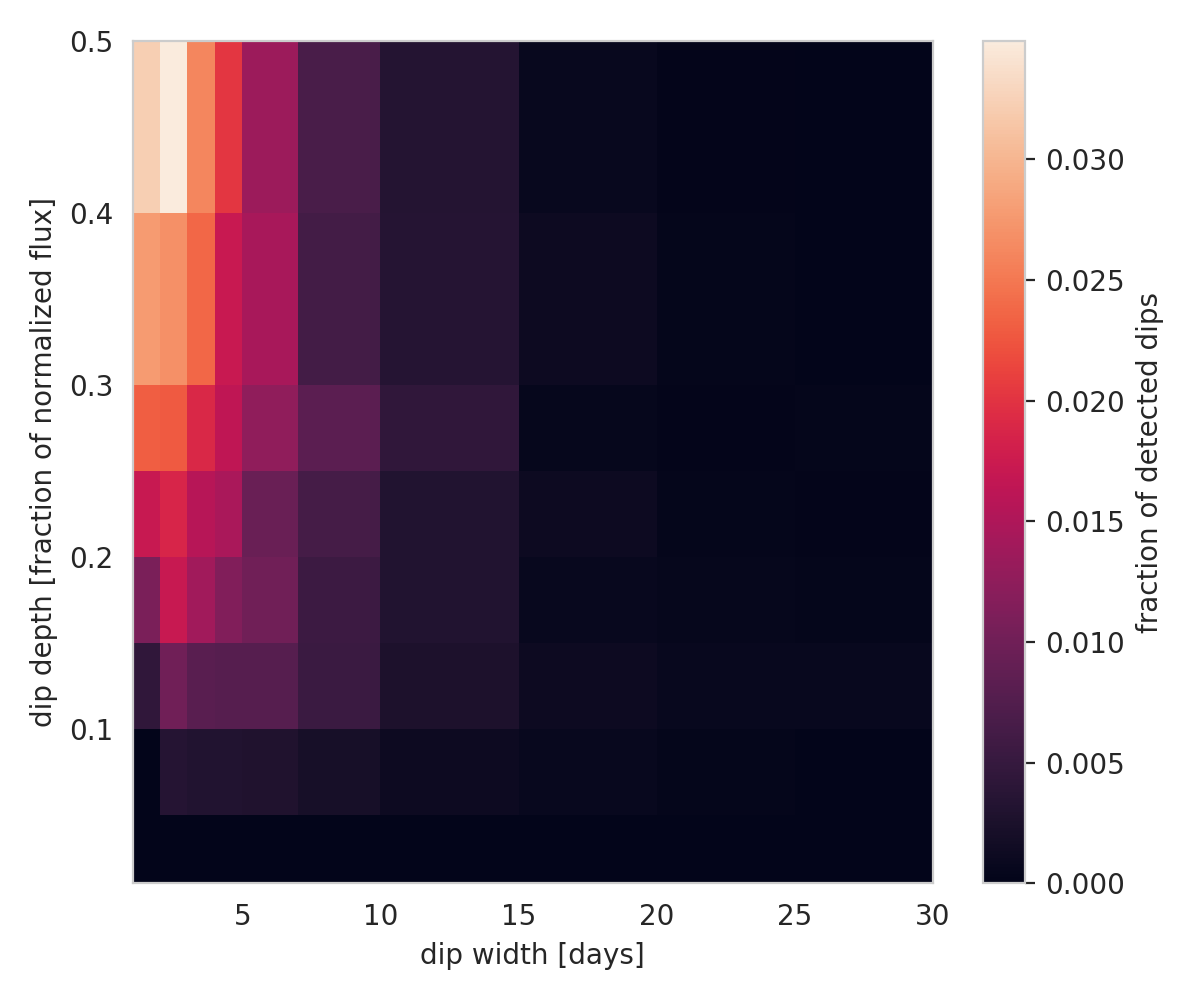

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(6,5))

im = ax.pcolormesh(widths, depths, dip_fraction)
cbar = fig.colorbar(im)
cbar.set_label('fraction of detected dips')

ax.set_xlabel("dip width [days]")
ax.set_ylabel("dip depth [fraction of normalized flux]")
plt.tight_layout()

It is surprising that we aren't sensitive to longer dips, so I'm going to plot some examples:

In [91]:
widths = [1, 2, 3, 4, 5, 7, 10, 15, 20, 25, 30]
depths = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]


In [101]:
res_long = res_all_sims[3][9]
lc_all_long = lc_all_sims[3][9]
dips = identify_dips(res_long)

In [102]:
len(dips)

1

<IPython.core.display.Javascript object>


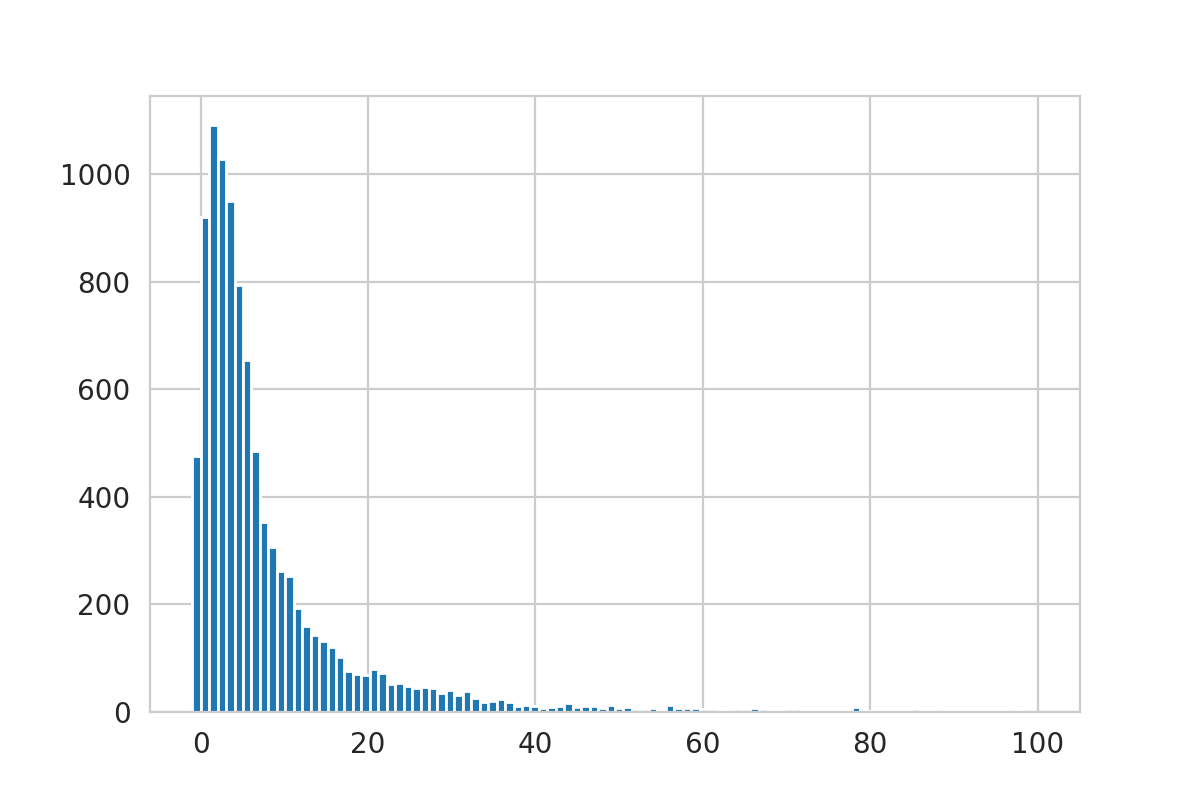

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(res_long["significance"], bins=100, range=[-1,100]);

In [103]:
dips

,integral,integral_uncertainty,significance,start_mjd,center_mjd,end_mjd,length,window_start_mjd,window_end_mjd,max_gap,ref_pull_std,ref_large_pull_fraction,observation_count,significant_observation_count,core_not_significant_fraction,significant_width
4234,7.673665,1.250167,6.138112,480.463245,496.566546,511.125629,30.662384,439.108208,556.225354,1.80036,1.11679,0.067669,56,33,0.053571,30.006001


In [142]:
lc_all_dip = lc_all_long[dips.index[0]]
lc_all_nodip = lc_all_long[res_long[res_long["significance"] > 40].index[200]]

<IPython.core.display.Javascript object>


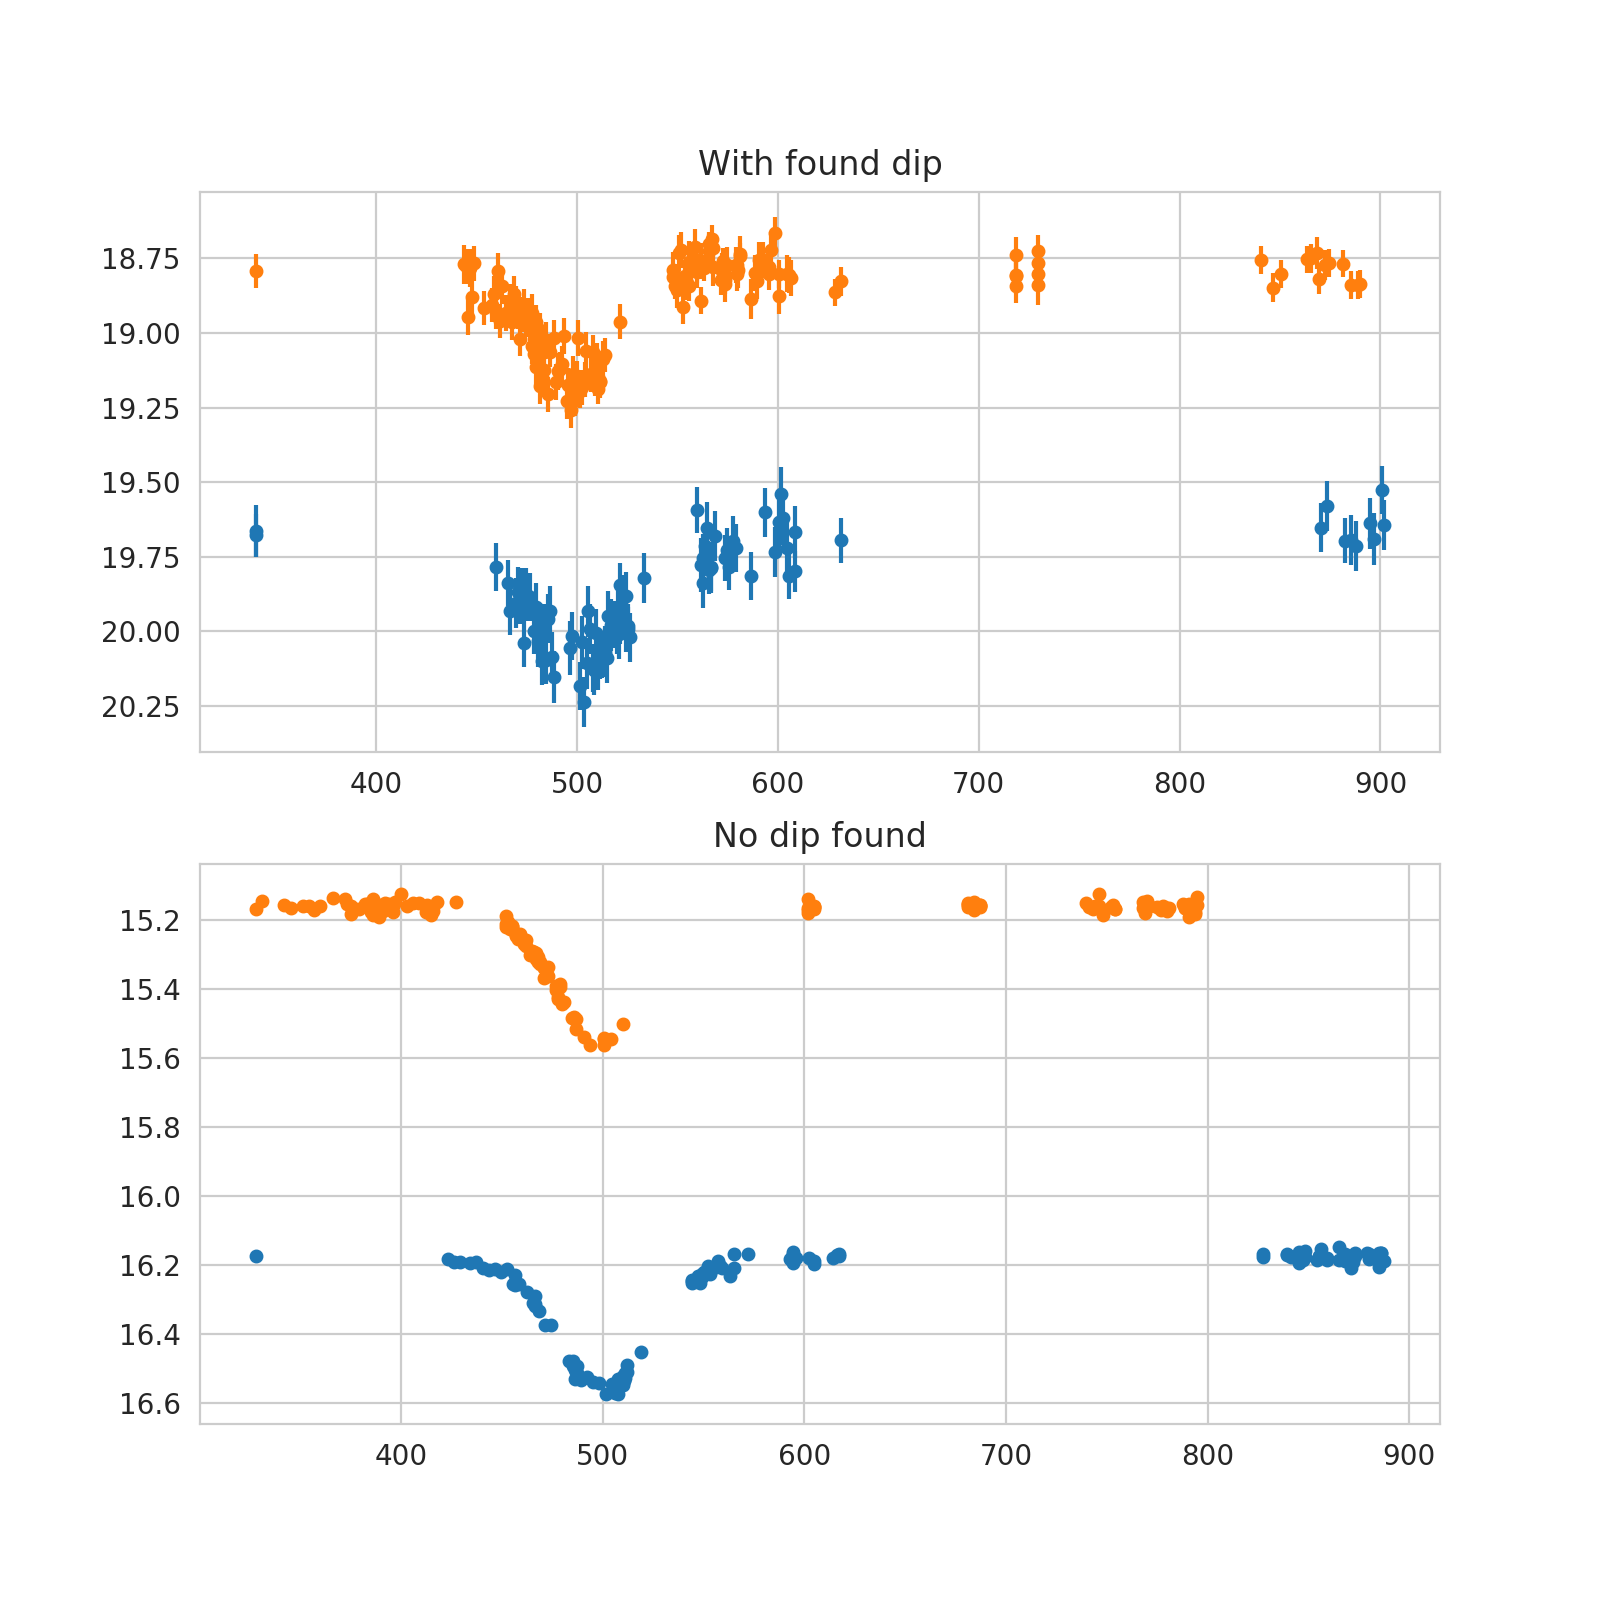

Text(0.5, 1.0, 'No dip found')

In [143]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))

for lcd, lcn in zip(lc_all_dip, lc_all_nodip):
    ax1.errorbar(lcd.time, lcd.flux, yerr=lcd.flux_err, fmt="o", markersize=4)
    ax2.errorbar(lcn.time, lcn.flux, yerr=lcn.flux_err, fmt="o", markersize=4)
    
ax1.set_ylim(ax1.get_ylim()[::-1])
ax2.set_ylim(ax2.get_ylim()[::-1])

ax1.set_title("With found dip")
ax2.set_title("No dip found")

In [125]:
for idx in res_long[res_long["significance"] > 40].index:
    lc_all = lc_all_long[idx]
    t_all = [lc.time for lc in lc_all]
    mag_all = [lc.flux for lc in lc_all]
    magerr_all = [lc.flux_err for lc in lc_all]

    res = measure_dip(t_all, mag_all, magerr_all)
    if res["significant_observation_count"] < 3:
        print("simulation %i"%idx)
        print("significant observation count: %.2f (should be >= 3 )"%res["significant_observation_count"])
    if res["core_not_significant_fraction"]  > 0.2:
        print("simulation %i"%idx)
        print("core_not_significant_fraction: %.2f (should be <= 0.2)"%res["core_not_significant_fraction"])
    if res["significant_width"] < 1:
        print("simulation %i"%idx)
        print("significant_width: %.2f (should be >= 1)"%res["significant_width"])
    if res["significance"] < 5:
        print("simulation %i"%idx)
        print("significance: %.2f (should be >= 5)"%res["significance"])
    if res["ref_pull_std"] >= 1.5:
        print("simulation %i"%idx)
        print("ref_pull_std: %.2f (should be < 1.5)"%res["ref_pull_std"])
    if res["ref_large_pull_fraction"] >= 0.1:
        print("simulation %i"%idx)
        print("ref_large_pull_fraction: %.4f (should be < 0.1)"%res["ref_large_pull_fraction"])
    if res["max_gap"] >= 2.0: 
        print("simulation %i"%idx)
        print("max_gap: %.2f (should be < 2.)"%res["max_gap"])
    print()

simulation 5
max_gap: 13.51 (should be < 2.)

simulation 71
max_gap: 22.80 (should be < 2.)

simulation 94
max_gap: 12.00 (should be < 2.)

simulation 99
ref_pull_std: 3.96 (should be < 1.5)
simulation 99
ref_large_pull_fraction: 0.7722 (should be < 0.1)
simulation 99
max_gap: 12.00 (should be < 2.)

simulation 122
max_gap: 6.67 (should be < 2.)

simulation 145
max_gap: 7.00 (should be < 2.)

simulation 152
ref_large_pull_fraction: 0.1562 (should be < 0.1)
simulation 152
max_gap: 13.92 (should be < 2.)

simulation 191
max_gap: 14.20 (should be < 2.)

simulation 215
ref_pull_std: 1.81 (should be < 1.5)
simulation 215
ref_large_pull_fraction: 0.6869 (should be < 0.1)
simulation 215
max_gap: 7.66 (should be < 2.)

simulation 241
ref_pull_std: 2.14 (should be < 1.5)
simulation 241
ref_large_pull_fraction: 0.4388 (should be < 0.1)
simulation 241
max_gap: 18.76 (should be < 2.)

simulation 255
max_gap: 6.00 (should be < 2.)

simulation 262
max_gap: 24.33 (should be < 2.)

simulation 317
max_


simulation 5403
ref_large_pull_fraction: 0.4472 (should be < 0.1)
simulation 5403
max_gap: 4.00 (should be < 2.)

simulation 5434
ref_pull_std: 2.60 (should be < 1.5)
simulation 5434
ref_large_pull_fraction: 0.6304 (should be < 0.1)
simulation 5434
max_gap: 6.00 (should be < 2.)

simulation 5436
ref_large_pull_fraction: 0.1940 (should be < 0.1)
simulation 5436
max_gap: 19.00 (should be < 2.)

simulation 5439
max_gap: 14.80 (should be < 2.)

simulation 5442
ref_large_pull_fraction: 0.8659 (should be < 0.1)
simulation 5442
max_gap: 4.00 (should be < 2.)

simulation 5525
max_gap: 13.80 (should be < 2.)

simulation 5575
max_gap: 10.00 (should be < 2.)

simulation 5796
max_gap: 320.26 (should be < 2.)

simulation 5865
ref_pull_std: 1.68 (should be < 1.5)
simulation 5865
ref_large_pull_fraction: 0.1774 (should be < 0.1)
simulation 5865
max_gap: 25.01 (should be < 2.)

simulation 5898
ref_large_pull_fraction: 0.1000 (should be < 0.1)
simulation 5898
max_gap: 3.00 (should be < 2.)

simulation